In [113]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, unix_timestamp, hour, weekofyear, month, quarter, dayofweek, dayofmonth, dayofyear, to_date
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [114]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [115]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler as sklearn_min_max_scaler
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler,  StringIndexer
#import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [116]:
spark = SparkSession.builder.config("spark.driver.memory", "4g").config("spark.executor.memory", "4g").appName("predictddc").getOrCreate()


In [117]:
#
parquet_path = "/home/hoan123/project-master/weather_data_transformed2024.csv"
df = spark.read.csv(parquet_path,header=True, inferSchema=True)

In [118]:
df_sorted = df.orderBy("datetime")  

In [119]:
df.show()

+-------------------+-----+-------+--------+---------+------+--------+---------+--------------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|precip_mm|           condition|
+-------------------+-----+-------+--------+---------+------+--------+---------+--------------------+
|2010-01-01 00:00:00|Hanoi|Vietnam| 21.0333|   105.85|  15.7|     7.3|      0.0|               Clear|
|2010-01-01 01:00:00|Hanoi|Vietnam| 21.0333|   105.85|  15.8|     7.1|      0.0|              Cloudy|
|2010-01-01 02:00:00|Hanoi|Vietnam| 21.0333|   105.85|  16.3|     6.8|      0.0|            Overcast|
|2010-01-01 03:00:00|Hanoi|Vietnam| 21.0333|   105.85|  16.8|     6.6|      0.0|              Cloudy|
|2010-01-01 04:00:00|Hanoi|Vietnam| 21.0333|   105.85|  17.3|     6.1|      0.1|   Patchy light rain|
|2010-01-01 05:00:00|Hanoi|Vietnam| 21.0333|   105.85|  17.5|     6.2|      0.0|Patchy light drizzle|
|2010-01-01 06:00:00|Hanoi|Vietnam| 21.0333|   105.85|  17.9|     5.4|      0.0|  

In [120]:
# Sắp xếp dữ liệu theo cột datetime
df_sorted = df.orderBy("datetime")


In [121]:
condition_to_index = {
    "Cloudy": 0,
    "Light rain": 1,
    "Patchy rain possible": 2,
    "Moderate or heavy rain shower": 3,
    "Patchy light rain": 4,
    "Clear": 5,
    "Partly cloudy": 6,
    "Sunny": 7,
    "Patchy light drizzle": 8,
    "Light drizzle": 9,
    "Patchy light rain with thunder": 10,
    "Mist": 11,
    "Moderate rain at times": 12,
    "Thundery outbreaks possible": 13,
    "Moderate or heavy rain with thunder": 14,
    "Overcast": 15,
    "Moderate rain": 16,
    "Light rain shower": 17,
    "Heavy rain": 18,
    "Heavy rain at times": 19,
    "Fog": 20
}

#
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def map_condition(condition):
    return condition_to_index.get(condition, 7)  # Trả về -1 nếu không tìm thấy giá trị phù hợp

map_condition_udf = udf(map_condition, IntegerType())

#
df_sorted = df_sorted.withColumn("condition_index", map_condition_udf("condition"))

#
df_sorted.show()


+-------------------+-----+-------+--------+---------+------+--------+---------+--------------------+---------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|precip_mm|           condition|condition_index|
+-------------------+-----+-------+--------+---------+------+--------+---------+--------------------+---------------+
|2010-01-01 00:00:00|Hanoi|Vietnam| 21.0333|   105.85|  15.7|     7.3|      0.0|               Clear|              5|
|2010-01-01 01:00:00|Hanoi|Vietnam| 21.0333|   105.85|  15.8|     7.1|      0.0|              Cloudy|              0|
|2010-01-01 02:00:00|Hanoi|Vietnam| 21.0333|   105.85|  16.3|     6.8|      0.0|            Overcast|             15|
|2010-01-01 03:00:00|Hanoi|Vietnam| 21.0333|   105.85|  16.8|     6.6|      0.0|              Cloudy|              0|
|2010-01-01 04:00:00|Hanoi|Vietnam| 21.0333|   105.85|  17.3|     6.1|      0.1|   Patchy light rain|              4|
|2010-01-01 05:00:00|Hanoi|Vietnam| 21.0333|   105.85|  

In [122]:

window = Window.orderBy("datetime")

#
df_with_lags = (
    df_sorted
    .withColumn("temp_c_t-1", lag("temp_c", 1).over(window))
    .withColumn("temp_c_t-2", lag("temp_c", 2).over(window))
    .withColumn("temp_c_t-3", lag("temp_c", 3).over(window))
    .withColumn("temp_c_t-4", lag("temp_c", 4).over(window))
    .withColumn("wind_mph_t-1", lag("wind_mph", 1).over(window))
    .withColumn("wind_mph_t-2", lag("wind_mph", 2).over(window))
    .withColumn("wind_mph_t-3", lag("wind_mph", 3).over(window))
    .withColumn("wind_mph_t-4", lag("wind_mph", 4).over(window))
    .withColumn("precip_mm_t-1", lag("precip_mm", 1).over(window))
    .withColumn("precip_mm_t-2", lag("precip_mm", 2).over(window))
    .withColumn("precip_mm_t-3", lag("precip_mm", 3).over(window))
    .withColumn("precip_mm_t-4", lag("precip_mm", 4).over(window))
    .withColumn("condition_t-1", lag("condition_index", 1).over(window))
    .withColumn("condition_t-2", lag("condition_index", 2).over(window))
    .withColumn("condition_t-3", lag("condition_index", 3).over(window))
    .withColumn("condition_t-4", lag("condition_index", 4).over(window))
    .withColumn("hour", hour("datetime"))
    .withColumn("day_of_month", dayofmonth("datetime"))
    .withColumn("day_of_week", dayofweek("datetime"))
    .withColumn("month", month("datetime"))
    .withColumn("quarter", quarter("datetime"))
    .withColumn("week", weekofyear("datetime"))
)

#
df_final = df_with_lags.select(
    "datetime", 
    "temp_c_t-1", "temp_c_t-2", "temp_c_t-3", "temp_c_t-4", 
    "wind_mph_t-1", "wind_mph_t-2","wind_mph_t-3","wind_mph_t-4",
    "precip_mm_t-1", "precip_mm_t-2","precip_mm_t-3","precip_mm_t-4",
    "condition_t-1", "condition_t-2", "condition_t-3", "condition_t-4",  
    "hour", "day_of_month", "day_of_week", "month", "quarter", "week", 
    "condition_index"  # Nhiệt độ hiện tại làm nhãn
).withColumnRenamed("condition_index", "label")

# Bỏ các hàng không đủ dữ liệu
df_final = df_final.na.drop()
df_final.show()


24/12/12 17:54:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+----------+----------+----------+----------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+----+------------+-----------+-----+-------+----+-----+
|           datetime|temp_c_t-1|temp_c_t-2|temp_c_t-3|temp_c_t-4|wind_mph_t-1|wind_mph_t-2|wind_mph_t-3|wind_mph_t-4|precip_mm_t-1|precip_mm_t-2|precip_mm_t-3|precip_mm_t-4|condition_t-1|condition_t-2|condition_t-3|condition_t-4|hour|day_of_month|day_of_week|month|quarter|week|label|
+-------------------+----------+----------+----------+----------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+----+------------+-----------+-----+-------+----+-----+
|2010-01-01 04:00:00|      16.8|      16.3|      15.8|      15.7|         6.6|         6.8|         7.1|         7.3|          0.0|          0.0|

24/12/12 17:54:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [123]:


# Thêm cột 'date' để lọc train-test
df_final = df_final.withColumn("date", to_date("datetime"))

# Chia dữ liệu train-test
train_data = df_final.filter(col("date") < "2022-10-30").drop("date")
test_data = df_final.filter(col("date") >= "2022-10-30").drop("date")

# Tạo feature vector
feature_cols = [
    "temp_c_t-1", "temp_c_t-2", "temp_c_t-3", "temp_c_t-4", 
    "wind_mph_t-1", "wind_mph_t-2", "wind_mph_t-3","wind_mph_t-4",
    "precip_mm_t-1", "precip_mm_t-2","precip_mm_t-3","precip_mm_t-4",
    "condition_t-1", "condition_t-2", "condition_t-3", "condition_t-4",
    "hour", "day_of_month", "day_of_week", "month", "quarter", "week"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = assembler.transform(train_data).select("features", "label", "datetime")
test_data = assembler.transform(test_data).select("features", "label", "datetime")


In [124]:
train_data.printSchema()


root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- datetime: timestamp (nullable = true)



In [125]:
from pyspark.sql.functions import col
train_data = train_data.withColumn("label", col("label").cast("int"))
test_data = test_data.withColumn("label", col("label").cast("int"))


In [126]:
from pyspark.sql.functions import col
train_data = train_data.na.drop()
test_data = test_data.na.drop()


In [127]:
train_data.select("label").show(1, truncate=False)

24/12/12 17:54:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----+
|label|
+-----+
|4    |
+-----+
only showing top 1 row



24/12/12 17:54:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [128]:
train_data.select("features").show(1, truncate=False)


24/12/12 17:54:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----------------------------------------------------------------------------------------------+
|features                                                                                       |
+-----------------------------------------------------------------------------------------------+
|[16.8,16.3,15.8,15.7,6.6,6.8,7.1,7.3,0.0,0.0,0.0,0.0,0.0,15.0,0.0,5.0,4.0,1.0,6.0,1.0,1.0,53.0]|
+-----------------------------------------------------------------------------------------------+
only showing top 1 row



24/12/12 17:54:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [130]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# === Random Forest ===

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, maxDepth=8)

# Huấn luyện mô hình Random Forest
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# === Logistic Regression ===

lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=50, regParam=0.1)

# Huấn luyện mô hình Logistic Regression
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# === Đánh giá hiệu năng ===
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Đánh giá Random Forest
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

# Đánh giá Logistic Regression
lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")

# === Feature Importance (Random Forest) ===
rf_feature_importances = rf_model.featureImportances
print("Random Forest Feature Importances:")
for idx, importance in enumerate(rf_feature_importances):
    print(f"Feature {idx}: {importance:.4f}")






24/12/12 17:54:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:54:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 1

Random Forest Accuracy: 0.6176277850589778


24/12/12 17:55:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Logistic Regression Accuracy: 0.45735037134119705
Random Forest Feature Importances:
Feature 0: 0.1493
Feature 1: 0.0932
Feature 2: 0.0518
Feature 3: 0.0241
Feature 4: 0.1058
Feature 5: 0.0346
Feature 6: 0.0081
Feature 7: 0.0070
Feature 8: 0.1524
Feature 9: 0.0492
Feature 10: 0.0191
Feature 11: 0.0057
Feature 12: 0.1928
Feature 13: 0.0591
Feature 14: 0.0170
Feature 15: 0.0065
Feature 16: 0.0161
Feature 17: 0.0007
Feature 18: 0.0003
Feature 19: 0.0035
Feature 20: 0.0012
Feature 21: 0.0027


Random Forest Feature Importances:
Feature 0: 0.1493
Feature 1: 0.0932
Feature 2: 0.0518
Feature 3: 0.0241
Feature 4: 0.1058
Feature 5: 0.0346
Feature 6: 0.0081
Feature 7: 0.0070
Feature 8: 0.1524
Feature 9: 0.0492
Feature 10: 0.0191
Feature 11: 0.0057
Feature 12: 0.1928
Feature 13: 0.0591
Feature 14: 0.0170
Feature 15: 0.0065
Feature 16: 0.0161
Feature 17: 0.0007
Feature 18: 0.0003
Feature 19: 0.0035
Feature 20: 0.0012
Feature 21: 0.0027


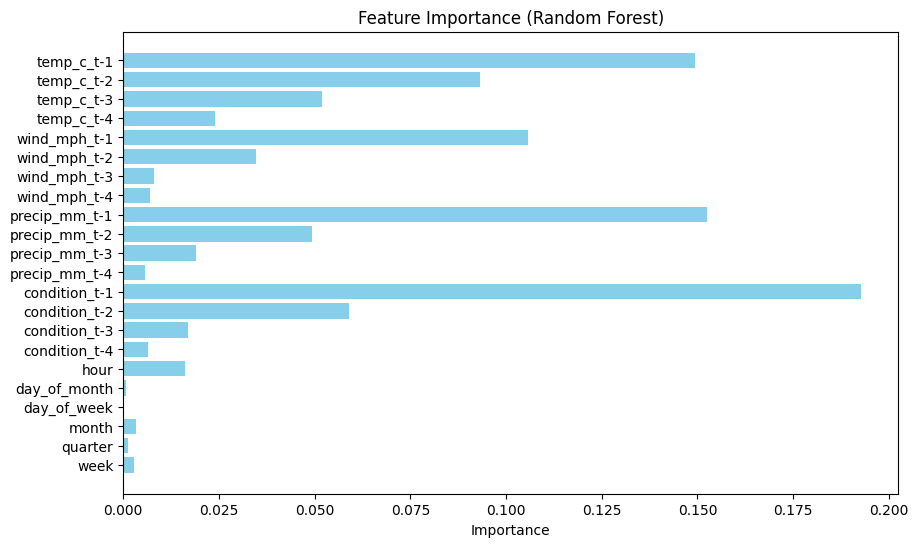

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# === Feature Importance (Random Forest) ===
rf_feature_importances = rf_model.featureImportances

print("Random Forest Feature Importances:")
for idx, importance in enumerate(rf_feature_importances):
    print(f"Feature {idx}: {importance:.4f}")

features = feature_cols  # 
importances = np.array(rf_feature_importances)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()  # Đảo ngược trục y để feature quan trọng nhất ở trên
plt.show()


In [136]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

24/12/12 17:55:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 1

Confusion Matrix for Random Forest:
[[ 264    0   48   51   42   94  379   37    0   84    0    0]
 [   1  298  404    1   52   40    0    0    0    0    2    0]
 [  28  192 2503   13  288  452   58    4    2   11    0    0]
 [ 276    2   53   59   60   92  391   27    0   61    0    0]
 [   6    8  326    3 2330  365   17    0    0    6    0    0]
 [  69    8  470   12  338 4755   89   38   11   16    0    0]
 [ 246    1   47   49   55  119  378   19    0   74    0    0]
 [  17    0    2    1    0   32   27  604    0    1    0    0]
 [   0    1   32    0    1  152    0    0   35    0    0    0]
 [ 225    0   48   40   57  108  404   30    0   81    0    0]
 [   0   50   75    0   12   12    0    0    0    0    3    0]
 [   0   14   16    0    0    2    0    0    0    0    6    0]]


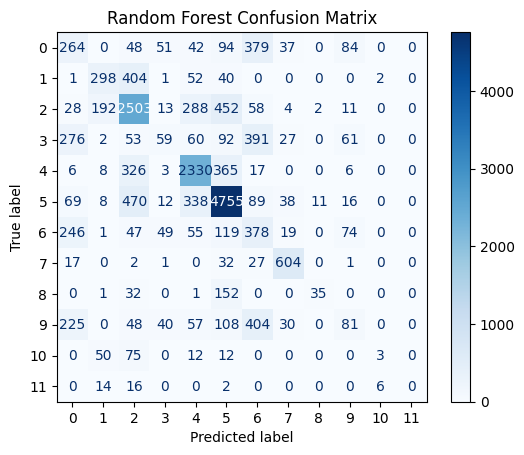

Confusion Matrix for Logistic Regression:
[[  13    0  354    0  192  322    6  110    0    2    0    0]
 [   0   71  483    0  122  122    0    0    0    0    0    0]
 [   3   43 1589    0  651 1239    2   24    0    0    0    0]
 [  19    0  348    1  215  313   15  104    0    6    0    0]
 [   0    2  359    0 1528 1172    0    0    0    0    0    0]
 [   1    2  415    1  607 4549    3  228    0    0    0    0]
 [  15    0  324    1  212  336   10   85    0    5    0    0]
 [   6    0   41    0    0   25    5  605    0    2    0    0]
 [   0    0   11    0    0  210    0    0    0    0    0    0]
 [  29    0  348    2  197  300    5  103    0    9    0    0]
 [   0   16   66    0   42   28    0    0    0    0    0    0]
 [   0   12   16    0    2    8    0    0    0    0    0    0]]


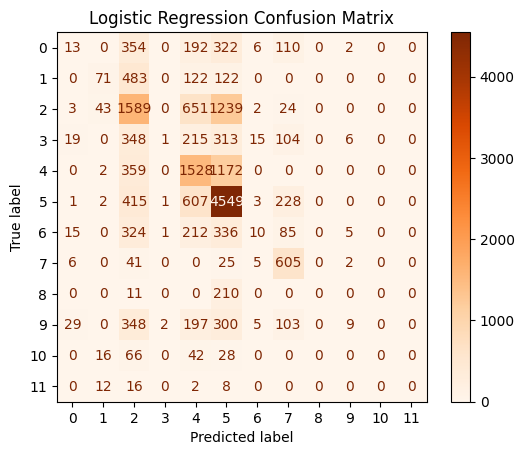

In [131]:
from pyspark.sql.functions import col
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

#
rf_predictions_pd = rf_predictions.select("label", "prediction").toPandas()
lr_predictions_pd = lr_predictions.select("label", "prediction").toPandas()

rf_conf_matrix = confusion_matrix(rf_predictions_pd['label'], rf_predictions_pd['prediction'])

print("Confusion Matrix for Random Forest:")
print(rf_conf_matrix)
ConfusionMatrixDisplay(confusion_matrix=rf_conf_matrix).plot(cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()

lr_conf_matrix = confusion_matrix(lr_predictions_pd['label'], lr_predictions_pd['prediction'])

print("Confusion Matrix for Logistic Regression:")
print(lr_conf_matrix)
ConfusionMatrixDisplay(confusion_matrix=lr_conf_matrix).plot(cmap="Oranges")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


In [132]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# === Naive Bayes ===
#
nb = NaiveBayes(labelCol="label", featuresCol="features", modelType="multinomial")

# Huấn luyện mô hình Naive Bayes
nb_model = nb.fit(train_data)
nb_predictions = nb_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Đánh giá Naive Bayes
nb_accuracy = evaluator.evaluate(nb_predictions)
print(f"Naive Bayes Accuracy: {nb_accuracy}")

##


24/12/12 17:55:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 1

Naive Bayes Accuracy: 0.10381170816950633


In [133]:
test_labels = rf_predictions.select("label").distinct().collect()
print(f"Unique labels in test set: {[row['label'] for row in test_labels]}")


24/12/12 17:55:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/12 17:55:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Unique labels in test set: [7, 6, 0, 5, 15, 8, 13, 4, 1, 16, 11, 18]


In [134]:
rf_model.write().overwrite().save("random_forest_model_condition")
lr_model.write().overwrite().save("logistic_regression_model_condition")

Py4JJavaError: An error occurred while calling o3073.save.
: java.io.IOException: Path random_forest_model_condition already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


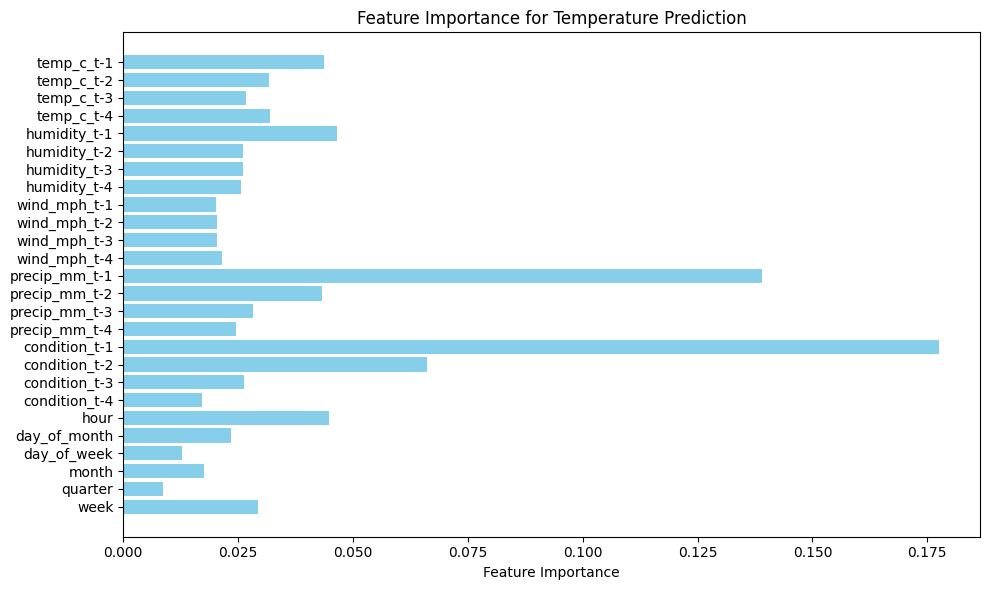

In [29]:
import matplotlib.pyplot as plt

# Dữ liệu feature importance
features = [
    "temp_c_t-1", "temp_c_t-2", "temp_c_t-3", "temp_c_t-4", 
    "humidity_t-1", "humidity_t-2", "humidity_t-3", "humidity_t-4",
    "wind_mph_t-1", "wind_mph_t-2", "wind_mph_t-3", "wind_mph_t-4",
    "precip_mm_t-1", "precip_mm_t-2", "precip_mm_t-3", "precip_mm_t-4",
    "condition_t-1", "condition_t-2", "condition_t-3", "condition_t-4",  
    "hour", "day_of_month", "day_of_week", "month", "quarter", "week"
]

importances = [
    0.0437, 0.0318, 0.0267, 0.0319, 
    0.0465, 0.0260, 0.0261, 0.0256, 
    0.0201, 0.0205, 0.0205, 0.0216, 
    0.1391, 0.0433, 0.0283, 0.0245, 
    0.1776, 0.0661, 0.0263, 0.0172, 
    0.0447, 0.0235, 0.0129, 0.0175, 0.0087, 0.0294
]

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Temperature Prediction")
plt.gca().invert_yaxis()  # Đảo ngược trục y để feature quan trọng nhất lên trên
plt.tight_layout()
plt.show()


In [30]:
from pyspark.ml.tuning import CrossValidatorModel

model_path = "random_forest_model"

cvModel = CrossValidatorModel.load(model_path)
rf_model = cvModel.bestModel

print(rf_model)


NameError: name 'fv' is not defined

In [ ]:
from pyspark.sql.functions import col, lag, hour, dayofmonth, dayofweek, month, quarter, weekofyear, to_date
from pyspark.sql.window import Window
#
parquet_path = "/home/hoan123/project-master/delta_lake/delta_lake_table_3/"
newdf = spark.read.parquet(parquet_path)
newdf_sorted = newdf.orderBy(col("datetime").desc()).limit(10)
#
window = Window.orderBy("datetime")

condition_to_index = {
    "Cloudy": 0,
    "Light rain": 1,
    "Patchy rain possible": 2,
    "Moderate or heavy rain shower": 3,
    "Patchy light rain": 4,
    "Clear": 5,
    "Partly cloudy": 6,
    "Sunny": 7,
    "Patchy light drizzle": 8,
    "Light drizzle": 9,
    "Patchy light rain with thunder": 10,
    "Mist": 11,
    "Moderate rain at times": 12,
    "Thundery outbreaks possible": 13,
    "Moderate or heavy rain with thunder": 14,
    "Overcast": 15,
    "Moderate rain": 16,
    "Light rain shower": 17,
    "Heavy rain": 18,
    "Heavy rain at times": 19,
    "Fog": 20
}

#
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

def map_condition(condition):
    return condition_to_index.get(condition, -1)  # Trả về -1 nếu không tìm thấy giá trị phù hợp

map_condition_udf = udf(map_condition, IntegerType())
newdf_sorted = newdf_sorted.withColumn("condition_index", map_condition_udf("condition"))

#
newdf_sorted.show()


+-------------------+-----+-------+--------+---------+------+--------+--------+---------+-------------+---------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|humidity|precip_mm|    condition|condition_index|
+-------------------+-----+-------+--------+---------+------+--------+--------+---------+-------------+---------------+
|2024-11-19 23:00:00|Hanoi|Vietnam| 21.0333|   105.85|  23.1|     3.8|    69.0|      0.0|Partly cloudy|              6|
|2024-11-19 22:00:00|Hanoi|Vietnam| 21.0333|   105.85|  23.8|     4.3|    66.0|      0.0|        Clear|              5|
|2024-11-19 21:00:00|Hanoi|Vietnam| 21.0333|   105.85|  24.5|     4.9|    62.0|      0.0|Partly cloudy|              6|
|2024-11-19 20:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.0|     4.5|    59.0|      0.0|Partly cloudy|              6|
|2024-11-19 19:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.8|     1.8|    55.0|      0.0|       Cloudy|              0|
|2024-11-19 18:00:00|Hanoi|Vietnam| 21.0

In [ ]:

newdf_with_lags = (
    newdf_sorted
    .withColumn("temp_c_t-1", lag("temp_c", 1).over(window))
    .withColumn("temp_c_t-2", lag("temp_c", 2).over(window))
    .withColumn("temp_c_t-3", lag("temp_c", 3).over(window))
    .withColumn("temp_c_t-4", lag("temp_c", 4).over(window))
    .withColumn("humidity_t-1", lag("humidity", 1).over(window))
    .withColumn("humidity_t-2", lag("humidity", 2).over(window))
    .withColumn("humidity_t-3", lag("humidity", 3).over(window))
    .withColumn("humidity_t-4", lag("humidity", 4).over(window))
    .withColumn("wind_mph_t-1", lag("wind_mph", 1).over(window))
    .withColumn("wind_mph_t-2", lag("wind_mph", 2).over(window))
    .withColumn("wind_mph_t-3", lag("wind_mph", 3).over(window))
    .withColumn("wind_mph_t-4", lag("wind_mph", 4).over(window))
    .withColumn("precip_mm_t-1", lag("precip_mm", 1).over(window))
    .withColumn("precip_mm_t-2", lag("precip_mm", 2).over(window))
    .withColumn("precip_mm_t-3", lag("precip_mm", 3).over(window))
    .withColumn("precip_mm_t-4", lag("precip_mm", 4).over(window))
    .withColumn("condition_t-1", lag("condition_index", 1).over(window))
    .withColumn("condition_t-2", lag("condition_index", 2).over(window))
    .withColumn("condition_t-3", lag("condition_index", 3).over(window))
    .withColumn("condition_t-4", lag("condition_index", 4).over(window))
    .withColumn("hour", hour("datetime"))
    .withColumn("day_of_month", dayofmonth("datetime"))
    .withColumn("day_of_week", dayofweek("datetime"))
    .withColumn("month", month("datetime"))
    .withColumn("quarter", quarter("datetime"))
    .withColumn("week", weekofyear("datetime"))
)

#
newdf_final = newdf_with_lags.select(
    "datetime", 
    "temp_c_t-1", "temp_c_t-2", "temp_c_t-3", "temp_c_t-4", 
    "humidity_t-1", "humidity_t-2", "humidity_t-3", "humidity_t-4",
    "wind_mph_t-1", "wind_mph_t-2","wind_mph_t-3","wind_mph_t-4",
    "precip_mm_t-1", "precip_mm_t-2","precip_mm_t-3","precip_mm_t-4",
    "condition_t-1", "condition_t-2", "condition_t-3", "condition_t-4",  
    "hour", "day_of_month", "day_of_week", "month", "quarter", "week",
    "condition_index"  # Nhiệt độ hiện tại làm nhãn
).withColumnRenamed("condition_index", "label")

##
newdf_final = newdf_final.na.drop()
#
feature_cols = [
    "temp_c_t-1", "temp_c_t-2", "temp_c_t-3", "temp_c_t-4", 
    "humidity_t-1", "humidity_t-2",  "humidity_t-3", "humidity_t-4",
    "wind_mph_t-1", "wind_mph_t-2", "wind_mph_t-3","wind_mph_t-4",
    "precip_mm_t-1", "precip_mm_t-2","precip_mm_t-3","precip_mm_t-4",
    "condition_t-1", "condition_t-2", "condition_t-3", "condition_t-4",
    "hour", "day_of_month", "day_of_week", "month", "quarter", "week"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
newdf_final = assembler.transform(newdf_final).select("features", "label", "datetime")

# Kết quả: DataFrame đã chuẩn bị để dự đoán
newdf_final.show()



24/12/10 16:19:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 1

+--------------------+-----+-------------------+
|            features|label|           datetime|
+--------------------+-----+-------------------+
|[27.4,28.7,28.8,2...|    5|2024-11-19 18:00:00|
|[26.4,27.4,28.7,2...|    0|2024-11-19 19:00:00|
|[25.8,26.4,27.4,2...|    6|2024-11-19 20:00:00|
|[25.0,25.8,26.4,2...|    6|2024-11-19 21:00:00|
|[24.5,25.0,25.8,2...|    5|2024-11-19 22:00:00|
|[23.8,24.5,25.0,2...|    6|2024-11-19 23:00:00|
+--------------------+-----+-------------------+



In [ ]:

predictions = rf_model.transform(newdf_final)


predictions.show()


predictions.select("datetime", "features", "label", "prediction").show()


24/12/10 16:19:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 1

+--------------------+-----+-------------------+--------------------+--------------------+----------+
|            features|label|           datetime|       rawPrediction|         probability|prediction|
+--------------------+-----+-------------------+--------------------+--------------------+----------+
|[27.4,28.7,28.8,2...|    5|2024-11-19 18:00:00|[0.26354412930457...|[0.00527088258609...|       7.0|
|[26.4,27.4,28.7,2...|    0|2024-11-19 19:00:00|[0.15047413417776...|[0.00300948268355...|       5.0|
|[25.8,26.4,27.4,2...|    6|2024-11-19 20:00:00|[8.37618595841209...|[0.16752371916824...|       5.0|
|[25.0,25.8,26.4,2...|    6|2024-11-19 21:00:00|[2.85981272330931...|[0.05719625446618...|       6.0|
|[24.5,25.0,25.8,2...|    5|2024-11-19 22:00:00|[2.57874450283250...|[0.05157489005665...|       6.0|
|[23.8,24.5,25.0,2...|    6|2024-11-19 23:00:00|[1.95715963015061...|[0.03914319260301...|       5.0|
+--------------------+-----+-------------------+--------------------+-------------

24/12/10 16:19:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:19:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 1

+-------------------+--------------------+-----+----------+
|           datetime|            features|label|prediction|
+-------------------+--------------------+-----+----------+
|2024-11-19 18:00:00|[27.4,28.7,28.8,2...|    5|       7.0|
|2024-11-19 19:00:00|[26.4,27.4,28.7,2...|    0|       5.0|
|2024-11-19 20:00:00|[25.8,26.4,27.4,2...|    6|       5.0|
|2024-11-19 21:00:00|[25.0,25.8,26.4,2...|    6|       6.0|
|2024-11-19 22:00:00|[24.5,25.0,25.8,2...|    5|       6.0|
|2024-11-19 23:00:00|[23.8,24.5,25.0,2...|    6|       5.0|
+-------------------+--------------------+-----+----------+



24/12/10 16:19:55 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
